In [1]:
from numpy.fft import *
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
import gc
from tensorflow.keras.datasets import mnist, fashion_mnist

## 利用PGD嵌入資訊

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_test = x_test[:1000]
del(x_train)
del(y_train)
del(y_test)
gc.collect()

num_classes = 10
image_shape = (28, 28, 1)
x_test = x_test.reshape((-1,) + image_shape)


iterations = 7  #攻擊次數
alpha = 0.0001  #攻擊程度
epsilon = 8.0 / 255  #攻擊範圍
#loss_object = tf.keras.losses.BinaryCrossentropy()  #我們選擇的loss function
#利用pgd的idea修改圖片 讓它生出我想要的label
def pgd_attack_to_target(input_image, target_label, loss_object, model, epsilon, alpha, iterations):
    x_adv = input_image  # 複製一個圖片 (不要動到原圖片)
    for i in range(iterations):  # 做很多次
        x_adv = tf.convert_to_tensor(x_adv)  # 將圖片轉成tensor
        with tf.GradientTape() as tape:  #開始計算梯度
            tape.watch(x_adv)  # 要計算的圖片是x_adv
            prediction = model(x_adv)  #先做判斷(取得目前的結果)
            loss = loss_object(target_label, prediction)  # 計算loss(距離target有多遠)
        grad = tape.gradient(loss, x_adv)  # 計算梯度 (loss對x_adv的梯度，d_loss/d_x_adv)
        x_adv_new  = x_adv - alpha * tf.sign(grad)  # 更新圖片(做梯度下降會讓預測結果接近我想要的label)
        x_adv = tf.clip_by_value(x_adv_new , x_adv - epsilon, x_adv + epsilon)  # 限制圖片的範圍
        x_adv = tf.clip_by_value(x_adv, 0, 1)  # 限制圖片的範圍(圖片要在0~1之間)
        x_adv = x_adv.numpy()  # 將圖片轉成numpy
    return x_adv  # 回傳攻擊後的圖片

In [3]:
BIT_COUNT = 16

list = np.array([ i for i in range(BIT_COUNT+1)])
user_code = np.eye(BIT_COUNT+1)[list]
print(user_code)  #生成onehot encoding

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [4]:
decoder = load_model('models/decoder_one_hot_4_bit_mnist_binary_crossentropy.h5')
x_test_adv = [x_test.copy() for i in range(BIT_COUNT+1)]
for epoch in range(20):
    print("epoch:",epoch+1)
    for i in range(1, BIT_COUNT+1):
        x_test_adv[i] = pgd_attack_to_target(x_test_adv[i], [user_code[i]] * len(x_test),
                                             tf.keras.losses.CategoricalCrossentropy(), decoder, epsilon, alpha,
                                             iterations)

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20


## 縮放攻擊

In [5]:
def rescale(x, scale):
    y = tf.image.resize(x, [int(x.shape[1] * scale), int(x.shape[2] * scale)])
    return tf.image.resize(y, [x.shape[1], x.shape[2]])

In [6]:
rescale_acc = []
scales = np.linspace(1.0, 0.04, 50)
for scale in scales:
    tmp_acc = []
    print("scale:",scale)
    for i in range(BIT_COUNT+1):
        _, acc = decoder.evaluate(rescale(x_test_adv[i], scale), np.array([user_code[i]] * len(x_test)))
        tmp_acc.append(acc)
    rescale_acc.append(np.mean(tmp_acc))
    del acc
    del tmp_acc
    gc.collect()

scale: 1.0
32/32 [==============================] - 0s 3ms/step - loss: 3.0680e-09 - categorical_accuracy: 1.0000
scale: 0.9804081632653061
32/32 [==============================] - 0s 6ms/step - loss: 1.0039e-09 - categorical_accuracy: 1.0000
scale: 0.9608163265306122
32/32 [==============================] - 0s 3ms/step - loss: 9.9647e-10 - categorical_accuracy: 1.0000
scale: 0.9412244897959183
32/32 [==============================] - 0s 6ms/step - loss: 9.9647e-10 - categorical_accuracy: 1.0000
scale: 0.9216326530612244
32/32 [==============================] - 0s 3ms/step - loss: 1.7184e-09 - categorical_accuracy: 1.0000
scale: 0.9020408163265307
32/32 [==============================] - 0s 6ms/step - loss: 1.7184e-09 - categorical_accuracy: 1.0000
scale: 0.8824489795918368
32/32 [==============================] - 0s 4ms/step - loss: 1.1296e-09 - categorical_accuracy: 1.0000
scale: 0.8628571428571429
32/32 [==============================] - 0s 6ms/step - loss: 1.1296e-09 - categorical_

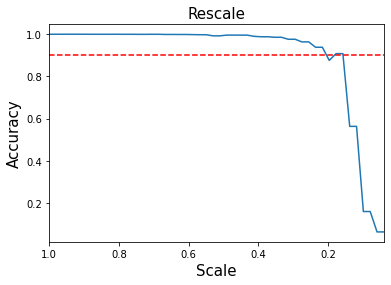

In [8]:
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(scales, rescale_acc)
plt.axhline(y=0.9,color='r',linestyle='--')
plt.xlim(max(scales), min(scales))
plt.xlabel("Scale",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.title("Rescale",fontsize=15)
plt.savefig("rescale_acc.png")
plt.show()